In [1]:
import h5py as h5
import vector
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def select_bjets(jets):
    jets = jets[jets['is_tagged']]
    # FIXME: you need to implement assignment of b tagged jets to bottom and anti-bottom quarks
    jets = np.take_along_axis(
        arr=jets,
        indices=np.argsort(jets['pt'])[::-1], 
        axis=0,
    )
    assert len(jets) >= 2
    return jets[:2]

def to_p4(arr):
    return vector.MomentumNumpy4D({
        key: arr[key]
        for key in ['pt', 'eta', 'phi', 'energy']
    })

In [19]:
# test set
path = '/users/seyang/data/nuflows/TTto2L2Nu/data/test.h5'

# output file created by export.py
nu_path = '../logs/nu2flows/test/outputs/test.h5'

In [4]:
with h5.File(path) as file:
    group = file['delphes']

    # NB use events with at least two b-tagged jets
    nbjets_mask = group['nbjets'][:] >= 2

    jet_arr = group['jets'][:][nbjets_mask]
    lepton_arr = group['leptons'][:][nbjets_mask]

In [7]:
bjet_arr = [select_bjets(each) for each in jet_arr]
bjet_arr = np.stack(bjet_arr)
# FIXME: you need to implement assignment of b tagged jets to bottom and anti-bottom quarks
b_arr = bjet_arr[:, 0]
anti_b_arr = bjet_arr[:, 1]

b_arr = to_p4(bjet_arr[:, 0])
anti_b_arr = to_p4(anti_b_arr)

In [8]:
lepton_arr = np.take_along_axis(
    arr=lepton_arr, 
    indices=np.argsort(lepton_arr['charge'], axis=1), 
    axis=1,
)
lep_neg_arr, lep_pos_arr = lepton_arr.T

In [9]:
lep_neg_arr = to_p4(lep_neg_arr)
lep_pos_arr = to_p4(lep_pos_arr)

In [10]:
with h5.File(nu_path) as file:
    anti_nu_arr = file['antineutrino'][:][nbjets_mask]
    nu_arr = file['neutrino'][:][nbjets_mask]

nu_arr = vector.MomentumNumpy4D(dict(
    px=nu_arr[:, 0],
    py=nu_arr[:, 1],
    pz=nu_arr[:, 2],
    mass=np.zeros_like(nu_arr[:, 0])
))

anti_nu_arr = vector.MomentumNumpy4D(dict(
    px=anti_nu_arr[:, 0],
    py=anti_nu_arr[:, 1],
    pz=anti_nu_arr[:, 2],
    mass=np.zeros_like(anti_nu_arr[:, 0])
))

In [11]:
w_neg_arr = lep_neg_arr + anti_nu_arr
w_pos_arr = lep_pos_arr + nu_arr

In [12]:
t_arr = b_arr + w_pos_arr
anti_t_arr = anti_b_arr + w_neg_arr

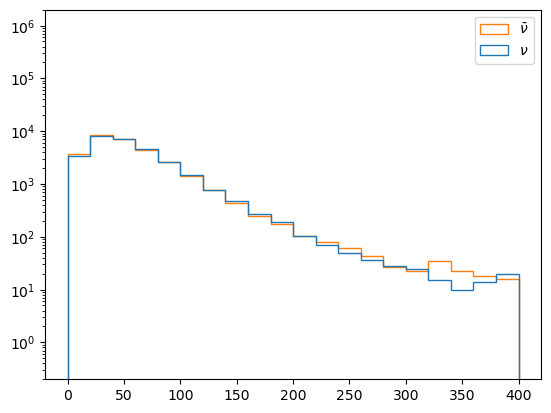

In [13]:
fig, ax = plt.subplots()
_ = ax.hist(
    [nu_arr.pt, anti_nu_arr.pt], 
    label=[r'$\nu$', r'$\bar{\nu}$'], 
    range=(0, 400), 
    bins=20, 
    histtype='step',
)
ax.set_yscale('log')
ax.set_ylim(0.2, 2e6) 
ax.legend()

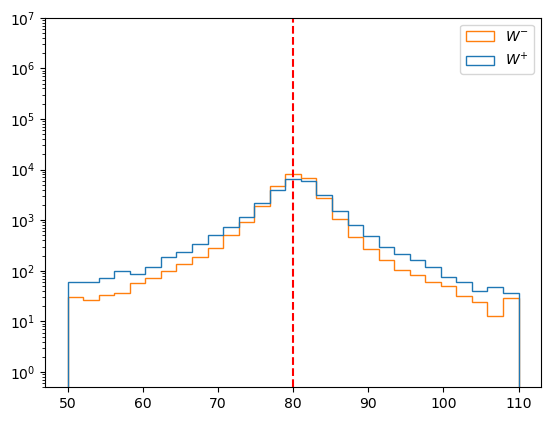

In [14]:
fig, ax = plt.subplots()

_ = ax.hist(
    [w_pos_arr.mass, w_neg_arr.mass], 
    label=[r'$W^{+}$', r'$W^{-}$'],
    range=(50, 110), 
    bins=29, 
    histtype='step',
)

ax.axvline(80, color='red', ls='--')
ax.set_yscale('log')
ax.set_ylim(5e-1, 1e7)
ax.legend()

Text(0.5, 1.0, 'm(t) looks wrong because our assignment strategy is dumb!!!')

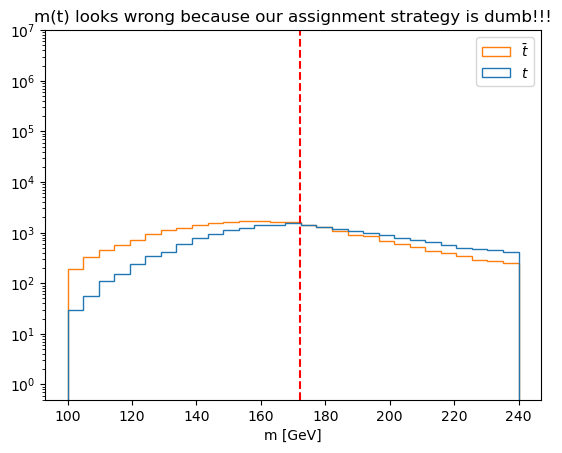

In [21]:
fig, ax = plt.subplots()

_ = ax.hist(
    [t_arr.mass, anti_t_arr.mass], 
    label=[r'$t$', r'$\bar{t}$'],
    range=(100, 240), 
    bins=29, 
    histtype='step',
)

ax.axvline(172, color='red', ls='--')
ax.set_yscale('log')
ax.set_ylim(5e-1, 1e7)
ax.legend()
ax.set_xlabel(r'm [GeV]')
ax.set_title('m(t) looks wrong because our assignment strategy is dumb!!!')